Dieser Quellcode ist Bestandteil der Dissertation von Ines Reinecke
vorgelegt am 11.07.2023 der Technischen Universität Dresden, Medizinische Fakultät

Dieser Code enthält 

* die initiale Datenanalyse (siehe Kapitel 3.4.2 "Systematische Analyse der Medikationsdaten am UKD")
* Verbesserung der Datenstruktur (siehe Kapitel 3.5.2 "Maßnahmen - Datenstruktur") 

Zunächst werden die Rohdaten aus Datensatz DS-Med (Medikationsverordnungen) und Datensatz DS-Katalog (Arzneimittelkatalog des UKD) eingelesen.
Anschließend wird der Datensatz DS-Med wie folgt im Detail geprüft:
* Summe der Arzneimittelverordnungen der Jahre 2016 bis 2020
* Ermittlung der fehlenden Arzneimitteleinträge in den Arzneimittelverordnungsdaten 
* Ermittlung der Menge der unstrukturierten Arzneimittelverordnungsdaten
* Gruppierung der unstrukturierten Arzneimittelverschreibungsdaten nach Medikationstext und Berechnung der Häufigkeit
* Überprüfung der Gesamtzahl der verschiedenen unstrukturierten Einträge für den Medikationstext
* Verteilung der Freitext-Arzneimittelverordnungen nach Häufigkeit auswerten
* Prüfung, ob die ersten 1000 häufigsten unstrukturierten Arzneimittelverordnungen für die manuelle Auswertung ausreichen, um das Ziel von 80% aller Arzneimittelverordnungen mit ATC-Code zu erreichen 
* Ausführen des Algorithmus auf den unstrukturierten Daten zur Bestimmung des ATC-Codes in STEP1 (Regex-Medikamentenprodukt), STEP2 (Inhaltsstoff) und STEP 3 (NLP basierend auf Ähnlichkeit mit Levenshtein-Distanz) - STEP 3 liefert bis zu 3 verschiedene vorgeschlagene ATC-Codes
* Ergebnisse zurückgeben und die häufigsten 1000 Einträge und Ergebnisse für Algorithmus 1, 2 und 3 erstellen
* Vorbereitung der Zahlen für die Visualisierung im Venn Chart, Übereinstimmung der Ergebnisse der Algorithmen


In [1]:
import pandas as pd
import numpy as np
import os
from fuzzywuzzy import fuzz, process
import re
from typing import List
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3, venn3_circles
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter
import warnings
warnings.filterwarnings("ignore")

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [6]:

# lesen Datensatz DS-Katalog
df_catalogue = pd.read_csv('../data_in/DS-Katalog.csv', sep=";", encoding = "UTF-8").fillna(str())

# lesen Datensatz DS-Med
df_med_orders = pd.read_csv('../data_in/DS-Med-initial.csv', skipinitialspace=True, low_memory=False, lineterminator='\n').fillna(str())

ATC = 'ATC-DIM'
ABDA = 'ABDA-Bezeichnung'

# Vorbereitung der Daten

df_med_orders['MEDICATION'] = df_med_orders['MEDICATION'].astype(str)

df_catalogue['ATC-WHO'] = [i[1:] for i in df_catalogue['ATC-WHO']]

df_med_orders_complete = df_med_orders


In [4]:
#Ausgabe der Anzahl der Medikationsverordnungen von 2016 bis 2020
print("total number of orders for all years from 2016 until 2020: ",len(df_med_orders))

df_med_orders.groupby(['CAT_MATCH']).count()

total number of orders for all years from 2016 until 2020:  1768153


,MED_CASE_NR,MEDICATION,ATC_CODE,START_DATE,END_DATE,UNIT
CAT_MATCH,,,,,,
Match,843980,843980,843980,843980,843980,843980
No Match,924173,924173,924173,924173,924173,924173


In [20]:
# Filter: entfernen aller Einträge die nach den Regeln keine Medikationsverordnungen sind

# Dataframe no_med generieren, welches nur die Verordnungen, die keine Medikationsverordnungen sind
no_med = df_med_orders[(df_med_orders['MEDICATION'].str.strip().str.startswith('BE ') 
          | df_med_orders['MEDICATION'].str.strip().str.startswith('BE:')
          | df_med_orders['MEDICATION'].str.strip().str.startswith('1 BE')
          | df_med_orders['MEDICATION'].str.strip().str.startswith('BB ')
          | df_med_orders['MEDICATION'].str.strip().str.startswith("!"))]


# aktualisiertes Dataframe nur mir tatsächlichen Medikationsverordnungen
df_med_orders = df_med_orders[~(df_med_orders['MEDICATION'].str.strip().str.startswith('BE ') 
          | df_med_orders['MEDICATION'].str.strip().str.startswith('BE:')
          | df_med_orders['MEDICATION'].str.strip().str.startswith('1 BE')
          | df_med_orders['MEDICATION'].str.strip().str.startswith('BB ')
          | df_med_orders['MEDICATION'].str.strip().str.startswith("!"))]


print("total number of orders for all years from 2016 until 2020 without no medication entries determined by rule set: ",len(df_med_orders))
print("total number of orders, that are not medication orders: ",len(no_med))

total number of orders for all years from 2016 until 2020 without no medication entries determined by rule set:  1607257
total number of orders, that are not medication orders:  160896


In [21]:
#Gruppierung des aktualisierten Dataframes ohne die no_med Einträge nochmal gruppieren nach strukturierten und unstrukturierten Medikationsverordnungen

df_med_orders.groupby(['CAT_MATCH']).count()

,BK_MEDICATION_ORDER,MEDICATION,ATC_CODE,START_DATE,END_DATE,UNIT
CAT_MATCH,,,,,,
Match,843980,843980,843980,843980,843980,843980
No Match,763277,763277,763277,763277,763277,763277


In [22]:
#Ausgabe der Anzahl strukturierter und unstrukturierter Medikationsverordnungen nochmal separat.
ana_med_orders = df_med_orders

df_struct = ana_med_orders.loc[ana_med_orders['CAT_MATCH'] == "Match"]
print("total number of orders for all years from 2016 until 2020 STRUCTURED: ",len(df_struct))
df_unstruct = ana_med_orders.loc[ana_med_orders['CAT_MATCH'] == "No Match"]
print("total number of orders for all years from 2016 until 2020 UNSTRUCTURED: ",len(df_unstruct))


total number of orders for all years from 2016 until 2020 STRUCTURED:  843980
total number of orders for all years from 2016 until 2020 UNSTRUCTURED:  763277


In [23]:
#unstrukturierte Medikamentenverordnungen nach der dem Freitext in der Spalte "MEDICATION"gruppieren und in einer separaten Spalte die Gesamtsumme berechnen
#Ziel: Visualisierung der ersten 1000 Zeilen von unstrukturierten Medikamentenverordnungen und deren Häufigkeit nach Medikamententext

df_unstruct = df_unstruct.assign(MEDICATION=df_unstruct['MEDICATION'].str.strip())


df_unstruct = df_unstruct.groupby(['MEDICATION', 'ATC_CODE', 'CAT_MATCH'], as_index=False).size().sort_values(by='size', ascending=False)
df_unstruct["cum_sum"] = df_unstruct['size'].cumsum()

Total = df_unstruct['size'].sum()
df_unstruct["percent"] = (df_unstruct['cum_sum'] / df_unstruct['size'].sum()) * 100
df_unstruct = df_unstruct.reset_index(drop=True)
df_unstruct

print("this is the percentage of frequency reached at row 1000: ", df_unstruct["percent"].iloc[999].round(decimals = 2))
print("this is the number of unstructured medication order amount at row 1000: ", df_unstruct["cum_sum"].iloc[999])


print("This is the percentage of total medication orders evaluated by taking the first 1000 most frequent unstructured medication orders for manual evaluation  and the already structured medication orders: ",(((df_unstruct['cum_sum'].iloc[999]+len(df_struct)+len(no_med)) / len(df_med_orders_complete)) * 100).round(decimals = 2) )



this is the percentage of frequency reached at row 1000:  65.66
this is the number of unstructured medication order amount at row 1000:  501183
This is the percentage of total medication orders evaluated by taking the first 1000 most frequent unstructured medication orders for manual evaluation  and the already structured medication orders:  85.18


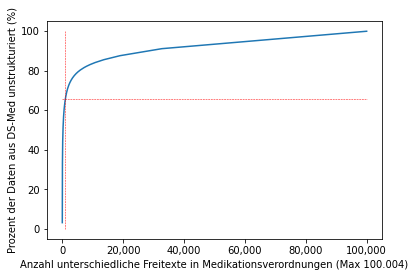

In [24]:
#Abbildung 4.10 (Kapitel Ergebnisse - 4.4.2.2 Ergebnisse der Validierung der Algorithmen)
# Anzeige der Top1000 Eiträge, für die Durchführung der manuellen Validierung

# Clear the current plot
plt.clf()

myplot = sns.lineplot(x = df_unstruct.index, y = "percent", data=df_unstruct)
myplot.vlines(x=1000, ymin=0, ymax=100, colors='r', linewidth=0.5, linestyle='dashed')
myplot.hlines(y=65.5666041423044, xmin=0, xmax=100000, colors='r', linewidth=0.5, linestyle='dashed')
65.5666041423044

myplot.get_xaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))


myplot.set_xlabel('Anzahl unterschiedliche Freitexte in Medikationsverordnungen (Max 100.004)')
myplot.set_ylabel('Prozent der Daten aus DS-Med unstrukturiert (%)')
figure = myplot.get_figure()   
figure.savefig('../data_results/Top1000.png', dpi=400, bbox_inches = "tight")

In [25]:
#df_med_orders['MEDICATION'] = df_med_orders['MEDICATION'].str.strip()
df_med_orders = df_med_orders.assign(MEDICATION=df_med_orders['MEDICATION'].str.strip())
df_med_orders = df_med_orders.groupby(['MEDICATION', 'ATC_CODE', 'CAT_MATCH'], as_index=False).size().sort_values(by='size', ascending=False)


# remove all rows of catalogue which do not have a given atc code
df_catalogue = df_catalogue[df_catalogue[ATC] != str()]


In [26]:
# einiges an pre-processing für die Wirkstoffe, hier wird eine neue Spalte eingefügt, wenn eine PIPE in dem Textfeld von "MEDICATION" vorhanden ist

abda = df_catalogue[ABDA]

df_catalogue['ingredient'] = [str(ing).lower() if str(ing2) == str() else str(ing2).lower() 
                              for ing, ing2 in zip(df_catalogue['Wirkstoff'], df_catalogue['enstpr. Wirkstoff'])]

# add boolean if ingredient is specified
df_med_orders['PIPE'] = [int(True) if "|" in med else int(False) for med in df_med_orders['MEDICATION']]

In [27]:
def print_array(arr : List) -> str:
    if isinstance(arr, str):
        return arr
    
    s = str()
    for i in arr:
        s += str(i) + " " 
    
    return s.rstrip()

In [28]:
# extract ingredient -> format drugs etc. | (ingredient)

def extract_ingredient(m : str) -> str:
    med = m.split("|")
    
    # was there a pipe in the string?
    if len(med) == 1:
        return str()
    
    # return ingredient in lower case and without brackets
    return re.sub('\s+',' ', med[-1]).lower().strip()[1:-1]
    
# if result is an empty string ingredient could still be in the medication name like ibuprofen
df_med_orders['INGREDIENT'] = [extract_ingredient(x) for x in df_med_orders['MEDICATION'].tolist()]

In [29]:
def arr_to_len_three(arr):
    arr = arr + [str()] * 3
    return arr[:3]

In [30]:
# Funktion für die drei Algorithmen
def algorithm(med : str, ing : str) -> List[str]:
    
    if ing != str():
        cat = df_catalogue[df_catalogue['ingredient'] == ing]
        
        # STEP 1 
        step1 = np.unique(cat[ATC])
        step1 = step1[0] if len(step1) == 1 else str()
           
    else: 
        cat = list()
        step1 = str()
    
    
    # remove the ingredient out of medication name -> not important for now because we extracted it
    med = med.split('|')[0]
    
    med_spl = med.split()
    # if there are more than 3 words, than just take the first 3, because these informations are more relevant 
    # and give better results
    if len(med_spl) > 3:
        med = print_array(med_spl[:3])

    
    # if there are no results 
    if not len(cat):
        res_med = process.extract(med, abda, limit=3, scorer=fuzz.token_set_ratio)
         
    else:
        res_med = process.extract(med, cat[ABDA].to_list(), limit=3, scorer=fuzz.token_set_ratio)
        
    
    # we only need catalogue as df -> medication should only exist once in catalogue for the exact same string
    df = pd.DataFrame()

    for i in range(len(res_med)):
        df = df.append(df_catalogue[df_catalogue[ABDA] == res_med[i][0]].iloc[0][['ABDA-Bezeichnung', 'ATC-DIM', 'ATC-WHO', 'DFO Bezeichnung', 'SAP-Kurztext']])
        
    # append the calculated values of the levenshtein distanc
    df['value_lev'] = [i[1] for i in res_med]
        
    df = df.drop_duplicates(subset=[ATC])

    # row = df[df[ATC] == codes[0]].iloc[0]
    
    # STEP 2
    step2 = list(np.unique(df_catalogue[df_catalogue[ABDA].str.contains(med, case=False, regex=False)][ATC]))
    step2 = step2[0] if len(step2) == 1 else str()

    
    
    # return -> all ATC-DIM, ATC-WHO, Levenshtein Distances,      
    return (step1,
            step2,
            arr_to_len_three(list(df[ATC])), 
            arr_to_len_three(list(df['ATC-WHO'])), 
            arr_to_len_three(list(df['value_lev'].astype(int))))



In [31]:
# Funktion um zu vergleichen ob die drei Algorithmen dieselben Ergebnisse zurückliefern
def compare_rows(atc1, atc2, atc3=False):
    if atc3 == False:
        atc3 = atc1
    
    if pd.isnull(atc1) or pd.isnull(atc2) or pd.isnull(atc3):
        return 0
    elif atc1 == atc2 and atc1 == atc3:
        return 1
    else: #  np.isnan(atc1) or np.isnan(atc2) or not (atc1 == atc2):
        return 2
    

In [32]:
# Main Funktion, die alle vorher definierten Funktionen nutzt

def main(df):
    # if ATC_CODE1 == ATC_CODE2 we got the right one
    print(f'Length df -> : {len(df)}')

    match = []
    
    meds = list(df['MEDICATION'])

    df['INGREDIENT'] = [extract_ingredient(x) for x in meds]
    
    df = df.reset_index()
    
    for index, med in enumerate(tqdm(zip(df['MEDICATION'], df['INGREDIENT']))):
        
        arr = algorithm(med[0], med[1])
        
                
        df.at[index, ['STEP1', 'STEP2']] = arr[:2]
        df.at[index, ['STEP31', 'STEP32', 'STEP33']] = arr[2]
        df.at[index, ['LEV1', 'LEV2', 'LEV3']] = arr[4]
    
    df['TRUE12'] = [compare_rows(atc1, atc2) for atc1, atc2 in zip(df['STEP1'], df['STEP2'])]                   
    df['TRUE123'] = [compare_rows(atc1, atc2, atc3) for atc1, atc2, atc3 in zip(df['STEP1'], df['STEP2'], df['STEP31'])]
    df['TRUE13'] = [compare_rows(atc1, atc2) for atc1, atc2 in zip(df['STEP1'], df['STEP31'])]
    df['TRUE23'] = [compare_rows(atc1, atc2) for atc1, atc2 in zip(df['STEP2'], df['STEP31'])]
    df['MATCH'] = [compare_rows(atc1, atc2) for atc1, atc2 in zip(df['ATC_CODE'], df['STEP31'])]

    # adding first atc level as extra column
    #df['ATC_LVL1_JOS'] = [atc[:1] for atc in df['ATC_JOS1']]
    #df['ATC_LVL1_MAR'] = [atc[:1] for atc in df['ATC_CODE']]
    df['LEV1'] = df['LEV1'].astype(int)
    
    return df


In [33]:
df = df_med_orders

#Aufruf Main
res = main(df)
del res['index']

# Hinzufügen einer neuen Spalte, die nur das 1. Level von ATC enthält
res['STEP31_LVL1'] = [atc[:1] for atc in res['STEP31']]
res['ATC_CODE_LVL1'] = [atc[:1] for atc in res['ATC_CODE']]



Length df -> : 101480


5129it [17:23,  4.92it/s]

KeyboardInterrupt



In [ ]:
#Speicherung der Resultate der Algorithmen auf die Freitexte

res.to_csv('../data_results/01_data_structure_results/res.csv', index=False)

In [ ]:
#Generierung des Subsets der Ergebnisse nur für die unstrukturierten Medikationverordnungen

res_un = res.loc[res['CAT_MATCH'] == "No Match"]

In [ ]:
#Limiiterung auf die ersten 1000 Zeilen

res1000 = res_un.head(n=1000)

In [ ]:
# Export und Speichern der kompletten Ergebnisse für die 1000 häufigsten Medikationsverordnungen

res1000.to_csv('../data_results/01_data_structure_results/res1000.csv', index=False)

In [ ]:
# Zur Information nur einige Printouts:
# Werden dann auch als Eingabewerte für die Visualisierung des Venn Charts, mit der Übereinstimmung der Anzahl der Ergebnisse zwischen den drei Algorithmen verwendet
print("Number of of different txt entries algorithm 1 identified an ATC code: ", len(res_un.loc[res_un['STEP1']!='']))
print("Total number of drug prescriptions algorithm 1 identified an ATC code: ", res_un["size"].loc[res_un['STEP1']!=''].sum())
print("Number of of different txt entries algorithm 2 identified an ATC code: ", len(res_un.loc[res_un['STEP2']!='']))
print("Total number of drug prescriptions algorithm 2 identified an ATC code: ", res_un["size"].loc[res_un['STEP2']!=''].sum())
print("Number of of different txt entries algorithm 3 identified an ATC code: ", len(res_un.loc[res_un['STEP31']!='']))
print("Total number of drug prescriptions algorithm 3 identified an ATC code: ", res_un["size"].loc[res_un['STEP31']!=''].sum())
print("****************************************************************************************************************")
print("Number of of different txt entries algorithm 1 + 2 results match: ", len(res_un.loc[res_un['TRUE12']==1].loc[res_un['STEP1']!='']))
print("Total number of drug prescriptions algorithm 1 + 2 results match: ", res_un["size"].loc[res_un['TRUE12']==1].loc[res_un['STEP1']!=''].sum())
print("Number of of different txt entries algorithm 1 + 3 results match: ", len(res_un.loc[res_un['TRUE13']==1].loc[res_un['STEP1']!='']))
print("Total number of drug prescriptions algorithm 1 + 3 results match: ", res_un["size"].loc[res_un['TRUE13']==1].loc[res_un['STEP1']!=''].sum())
print("Number of of different txt entries algorithm 2 + 3 results match: ", len(res_un.loc[res_un['TRUE23']==1].loc[res_un['STEP2']!='']))
print("Total number of drug prescriptions algorithm 2 + 3 results match: ", res_un["size"].loc[res_un['TRUE23']==1].loc[res_un['STEP2']!=''].sum())
print("Number of of different txt entries algorithm 1 + 2 + 3 results match: ", len(res_un.loc[res_un['TRUE123']==1].loc[res_un['STEP2']!='']))
print("Total number of drug prescriptions algorithm 1 + 2 + 3 results match: ", res_un["size"].loc[res_un['TRUE123']==1].loc[res_un['STEP2']!=''].sum())
print("****************************************************************************************************************")
print("TOP 1000 - Number of of different txt entries algorithm 1 + 2 results match: ", len(res1000.loc[res1000['TRUE12']==1].loc[res1000['STEP1']!='']))
print("TOP 1000 - Total number of drug prescriptions algorithm 1 + 2 results match: ", res1000["size"].loc[res1000['TRUE12']==1].loc[res1000['STEP1']!=''].sum())
print("TOP 1000 - Number of of different txt entries algorithm 1 + 3 results match: ", len(res1000.loc[res1000['TRUE13']==1].loc[res1000['STEP1']!='']))
print("TOP 1000 - Total number of drug prescriptions algorithm 1 + 3 results match: ", res1000["size"].loc[res1000['TRUE13']==1].loc[res1000['STEP1']!=''].sum())
print("TOP 1000 - Number of of different txt entries algorithm 2 + 3 results match: ", len(res1000.loc[res1000['TRUE23']==1].loc[res1000['STEP2']!='']))
print("TOP 1000 - Total number of drug prescriptions algorithm 2 + 3 results match: ", res1000["size"].loc[res1000['TRUE23']==1].loc[res1000['STEP2']!=''].sum())
print("TOP 1000 - Number of of different txt entries algorithm 1 + 2 + 3 results match: ", len(res1000.loc[res1000['TRUE123']==1].loc[res1000['STEP2']!='']))
print("TOP 1000 - Total number of drug prescriptions algorithm 1 + 2 + 3 results match: ", res1000["size"].loc[res1000['TRUE123']==1].loc[res1000['STEP2']!=''].sum())
print("****************************************************************************************************************")
print("TOP 1000 - Number of of different txt entries algorithm 1 identified an ATC code: ", len(res1000.loc[res1000['STEP1']!='']))
print("TOP 1000 - Total number of drug prescriptions algorithm 1 identified an ATC code: ", res1000["size"].loc[res1000['STEP1']!=''].sum())
print("TOP 1000 - Number of of different txt entries algorithm 2 identified an ATC code: ", len(res1000.loc[res1000['STEP2']!='']))
print("TOP 1000 - Total number of drug prescriptions algorithm 2 identified an ATC code: ", res1000["size"].loc[res1000['STEP2']!=''].sum())
print("TOP 1000 - Number of of different txt entries algorithm 3 identified an ATC code: ", len(res1000.loc[res1000['STEP31']!='']))
print("TOP 1000 - Total number of drug prescriptions algorithm 3 identified an ATC code: ", res1000["size"].loc[res1000['STEP31']!=''].sum())